
# Hybrid pipeline: Classical features + ResNet + XGBoost

This notebook integrates the **mask-derived tabular features** with your existing **ResNet** branch and trains an **XGBoost** classifier.

**What it does**
1. Read case lists: `train_cases.csv`, `val_cases.csv` (and optionally `test_cases.csv`).
2. For each case (subject ID), compute **classical features** from QSM/NM/T1 + masks.
3. Optionally merge **ResNet probabilities** (if you have per-subject outputs).
4. Train on **train**, evaluate on **val**.
5. Retrain on **train+val** and run **test** (evaluate if labels exist, else just save predictions).
6. Save everything to an `out/` folder next to your data.



## 0) Requirements
This notebook expects:
- A directory layout like:
```
DATA_ROOT/
  train/
    RJPD_001/
      QSM.nii.gz   QSM_mask.nii.gz   NM.nii.gz   NM_mask.nii.gz   T1.nii.gz
    RJPD_002/ ...
  val/
    RJPD_.../ (same pattern)
  test/
    RJPD_.../ (same pattern)
  train_cases.csv
  val_cases.csv
  (optional) test_cases.csv
```
- `classical_features.py` in the same folder as this notebook (or on your Python path).
- Optional ResNet predictions CSVs (see the config cell below).



## 1) Setup
Installs (if needed) and imports.


In [1]:

# If imports fail, install with %pip in Jupyter
try:
    import numpy as np, pandas as pd, nibabel as nib
    from tqdm import tqdm
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
    import joblib
    import xgboost as xgb
except Exception:
    %pip install -q numpy pandas nibabel tqdm scikit-learn xgboost joblib
    import numpy as np, pandas as pd, nibabel as nib
    from tqdm import tqdm
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
    import joblib
    import xgboost as xgb

from pathlib import Path



## 2) Configuration
Set your data root and where to find case CSVs and (optionally) ResNet predictions.


In [3]:

import os
from pathlib import Path

# ---- CHANGE THIS to your dataset root (or set env var PARKINSONS_DATA_ROOT) ----
DATA_ROOT = Path(os.getenv("PARKINSONS_DATA_ROOT") or Path.cwd()).resolve()
print("DATA_ROOT =", DATA_ROOT)

# Case lists
TRAIN_CASES_CSV = DATA_ROOT / "train_cases (2).csv"   # uploaded
VAL_CASES_CSV   = DATA_ROOT / "val_cases (2).csv"     # uploaded
#TEST_CASES_CSV  = DATA_ROOT / "test_cases.csv"    # optional

# Split folders (must exist if used)
SPLIT_DIRS = {
    "train": DATA_ROOT / "train",
    "val":   DATA_ROOT / "val",
    "test":  DATA_ROOT / "test",
}

# Optional: paths to per-subject ResNet probabilities (CSV with columns: subject_id, resnet_prob)
# You can generate these via your existing ResNet inference code and point to the CSVs here.
RESNET_PRED_CSV = {
    "train": DATA_ROOT / "cnn_preds" / "resnet_train.csv",
    "val":   DATA_ROOT / "cnn_preds" / "resnet_val.csv",
    "test":  DATA_ROOT / "cnn_preds" / "resnet_test.csv",
}

# Output directory
OUT_DIR = DATA_ROOT / "out"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR =", OUT_DIR)


DATA_ROOT = C:\Users\rubia\Downloads
OUT_DIR = C:\Users\rubia\Downloads\out



## 3) Utilities: loading cases, labels, and ResNet predictions
We try to autodetect the subject ID column and the label column.
Accepted label values: `PD/HC`, `1/0`, `case/control`, etc.


In [5]:

import pandas as pd
import re

ID_CANDIDATES = ["subject_id","case_id","id","ID","Subject","subject","Case","case"]
Y_CANDIDATES  = ["label","y","target","class","diagnosis","Diagnosis","group","Group"]

def read_cases(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        print(f"[read_cases] Missing CSV: {csv_path}")
        return pd.DataFrame()
    df = pd.read_csv(csv_path)
    # Find id column
    id_col = None
    for c in ID_CANDIDATES:
        if c in df.columns:
            id_col = c
            break
    if id_col is None:
        # fallback to first column
        id_col = df.columns[0]
    df = df.rename(columns={id_col: "subject_id"})
    # Try find label col (optional for test)
    y_col = None
    for c in Y_CANDIDATES:
        if c in df.columns:
            y_col = c
            break
    if y_col:
        df = df.rename(columns={y_col: "label"})
    else:
        df["label"] = np.nan
    # normalize subject ids to strings
    df["subject_id"] = df["subject_id"].astype(str)
    return df[["subject_id","label"]]

def normalize_label(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {"pd","p","1","case","patient","parkinson","parkinson's"}:
        return 1
    if s in {"hc","0","control","healthy"}:
        return 0
    # try int
    try:
        return int(float(s))
    except:
        return np.nan

def load_resnet_preds(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        print(f"[resnet] no preds at {csv_path} (skipping)")
        return pd.DataFrame(columns=["subject_id","resnet_prob"])
    df = pd.read_csv(csv_path)
    # standardize col names
    cols = {c.lower(): c for c in df.columns}
    # find subject id and prob columns
    sid_col = next((c for c in df.columns if c.lower() in {"subject_id","id","case_id","subject"}), df.columns[0])
    prob_col = next((c for c in df.columns if "prob" in c.lower() or "score" in c.lower() or "logit" in c.lower()), df.columns[-1])
    out = df[[sid_col, prob_col]].copy()
    out.columns = ["subject_id","resnet_prob"]
    out["subject_id"] = out["subject_id"].astype(str)
    return out



## 4) Classical features
We reuse the module created earlier to compute volumes + intensity stats.


In [10]:

from classical_features import extract_subject_features, merge_rows

def find_nii(folder: Path, stem: str):
    # try both .nii.gz and .nii
    for ext in (".nii.gz",".nii"):
        p = folder / f"{stem}{ext}"
        if p.exists():
            return p
    return None

def build_features_for_split(split: str, cases_df: pd.DataFrame) -> pd.DataFrame:
    split_dir = SPLIT_DIRS[split]
    rows = []
    for sid in tqdm(cases_df["subject_id"].tolist(), desc=f"{split} features"):
        subj = split_dir / sid
        if not subj.exists():
            # allow for subjects stored directly (flat layout), fallback to DATA_ROOT
            subj = split_dir  # last resort

        qsm_img = find_nii(subj, "QSM")
        qsm_mask = find_nii(subj, "QSM_mask")  # can be binary or multi-label
        nm_img  = find_nii(subj, "NM")
        nm_mask = find_nii(subj, "NM_mask")    # can be binary or multi-label
        t1_img  = find_nii(subj, "T1")

        # Flexible calls: atlas not required; pass binary masks via the *_binary functions if needed.
        features = {}

        # QSM global + masked stats
        if qsm_img:
            # global
            features.update(extract_subject_features(
                subject_id=sid,
                qsm_image_path=qsm_img,
                include_global_stats_for=[("QSM", None)]
            ).iloc[0].drop(labels=["subject_id"]).to_dict())

        # Handle QSM mask via binary-masks helper by constructing a mapping with a single entry,
        # or treat as atlas when multi-label labels exist. Here we'll just add a single "MASK" entry.
        if qsm_img and qsm_mask:
            # mark for downstream reader: this is a generic mask; if multi-label expected,
            # consider adapting classical_features to read per-label volumes as needed.
            # For now we compute aggregate masked stats via the quick function below.
            import nibabel as nib, numpy as np
            from classical_features import load_nifti
            qsm = load_nifti(qsm_img)
            m   = load_nifti(qsm_mask).data.astype(np.int64)
            labels = np.unique(m); labels = labels[labels != 0]
            # one label vs multi-label
            if labels.size <= 1:
                mask_bool = m.astype(bool)
                vox_count = int(np.count_nonzero(mask_bool))
                vol_mm3 = float(vox_count * qsm.voxel_volume_mm3)
                vals = qsm.data[mask_bool & np.isfinite(qsm.data)]
                import numpy as np
                def _s(v):
                    if v.size == 0: 
                        return dict(mean=np.nan,std=np.nan,median=np.nan,p10=np.nan,p90=np.nan,min=np.nan,max=np.nan)
                    return dict(
                        mean=float(np.mean(v)),
                        std=float(np.std(v, ddof=1)) if v.size>1 else (0.0 if v.size==1 else np.nan),
                        median=float(np.median(v)),
                        p10=float(np.percentile(v,10)),
                        p90=float(np.percentile(v,90)),
                        min=float(np.min(v)),
                        max=float(np.max(v)),
                    )
                s = _s(vals)
                features.update({"QSM_MASK_vol_mm3": vol_mm3, **{f"QSM_MASK_{k}":v for k,v in s.items()}})
            else:
                # per label
                from classical_features import _masked_vals  # type: ignore (internal)
                for lab in labels:
                    mask_bool = (m == lab)
                    vox_count = int(np.count_nonzero(mask_bool))
                    vol_mm3 = float(vox_count * qsm.voxel_volume_mm3)
                    vals = _masked_vals(qsm.data, mask_bool)
                    def _s(v):
                        if v.size == 0: 
                            return dict(mean=np.nan,std=np.nan,median=np.nan,p10=np.nan,p90=np.nan,min=np.nan,max=np.nan)
                        return dict(
                            mean=float(np.mean(v)),
                            std=float(np.std(v, ddof=1)) if v.size>1 else (0.0 if v.size==1 else np.nan),
                            median=float(np.median(v)),
                            p10=float(np.percentile(v,10)),
                            p90=float(np.percentile(v,90)),
                            min=float(np.min(v)),
                            max=float(np.max(v)),
                        )
                    s = _s(vals)
                    features.update({f"QSM_label_{int(lab)}_vol_mm3": vol_mm3, **{f"QSM_label_{int(lab)}_{k}":v for k,v in s.items()}})

        # NM global + SN L/R if labels 1/2
        if nm_img:
            features.update(extract_subject_features(
                subject_id=sid,
                nm_image_path=nm_img,
                include_global_stats_for=[("NM", None)]
            ).iloc[0].drop(labels=["subject_id"]).to_dict())

        if nm_img and nm_mask:
            from classical_features import load_nifti
            nm = load_nifti(nm_img)
            m  = load_nifti(nm_mask).data.astype(np.int64)
            labels = np.unique(m); labels = labels[labels != 0]
            # SN L/R = 1/2
            if 1 in labels and 2 in labels:
                from classical_features import extract_nm_sn_lr_features_from_multilabel
                feats = extract_nm_sn_lr_features_from_multilabel(nm_img, nm_mask, left_label=1, right_label=2)
                features.update(feats)
                # total SN volume
                mask_total = (m==1) | (m==2)
                vox = int(np.count_nonzero(mask_total))
                features["NM_SN_total_vol_mm3"] = float(vox * nm.voxel_volume_mm3)
            else:
                # generic mask stats
                mask_bool = m.astype(bool)
                vox = int(np.count_nonzero(mask_bool))
                features["NM_MASK_vol_mm3"] = float(vox * nm.voxel_volume_mm3)
                vals = nm.data[mask_bool & np.isfinite(nm.data)]
                import numpy as np
                if vals.size == 0:
                    stats = dict(mean=np.nan,std=np.nan,median=np.nan,p10=np.nan,p90=np.nan,min=np.nan,max=np.nan)
                else:
                    stats = {
                        "mean": float(np.mean(vals)),
                        "std": float(np.std(vals, ddof=1)) if vals.size>1 else (0.0 if vals.size==1 else np.nan),
                        "median": float(np.median(vals)),
                        "p10": float(np.percentile(vals,10)),
                        "p90": float(np.percentile(vals,90)),
                        "min": float(np.min(vals)),
                        "max": float(np.max(vals)),
                    }
                features.update({f"NM_MASK_{k}": v for k,v in stats.items()})

        # T1 global
        if t1_img:
            from classical_features import extract_global_modality_stats
            feats = extract_global_modality_stats(t1_img, prefix="T1")
            features.update(feats)

        row = {"subject_id": sid, **features}
        rows.append(pd.DataFrame([row]))

    df = merge_rows(rows)
    return df



## 5) Build features and merge with labels + ResNet


In [13]:

# --- Load case lists (train/val only) ---
train_df = read_cases(TRAIN_CASES_CSV)
val_df   = read_cases(VAL_CASES_CSV)

# Normalize labels (if present)
for df in (train_df, val_df):
    if "label" in df.columns:
        df["label"] = df["label"].apply(normalize_label)

display(train_df.head())
display(val_df.head())

# --- Extract features for train/val ---
train_feats = build_features_for_split("train", train_df) if not train_df.empty else pd.DataFrame()
val_feats   = build_features_for_split("val",   val_df)   if not val_df.empty   else pd.DataFrame()

# --- Auto-discover TEST subjects from the folder (no CSV needed) ---
test_dir = SPLIT_DIRS.get("test")
if test_dir is not None and test_dir.exists():
    test_ids = sorted([p.name for p in test_dir.iterdir() if p.is_dir()])
    test_df  = pd.DataFrame({"subject_id": test_ids})
    test_feats = build_features_for_split("test", test_df) if len(test_ids) else pd.DataFrame()
else:
    test_df = pd.DataFrame(columns=["subject_id"])
    test_feats = pd.DataFrame()

# --- Save features ---
if not train_feats.empty: train_feats.to_csv(OUT_DIR / "features_train.csv", index=False)
if not val_feats.empty:   val_feats.to_csv(OUT_DIR / "features_val.csv", index=False)
if not test_feats.empty:  test_feats.to_csv(OUT_DIR / "features_test.csv", index=False)

# --- Merge ResNet predictions if available (optional) ---
def attach_resnet(df_feats: pd.DataFrame, split: str) -> pd.DataFrame:
    preds = load_resnet_preds(RESNET_PRED_CSV[split])
    if preds.empty:
        return df_feats
    return df_feats.merge(preds, on="subject_id", how="left")

train_feats = attach_resnet(train_feats, "train") if not train_feats.empty else train_feats
val_feats   = attach_resnet(val_feats,   "val")   if not val_feats.empty   else val_feats
test_feats  = attach_resnet(test_feats,  "test")  if not test_feats.empty  else test_feats

# --- Attach labels to train/val only ---
train_merged = train_feats.merge(train_df, on="subject_id", how="left")
val_merged   = val_feats.merge(val_df,     on="subject_id", how="left")

# Test has no labels; keep as-is (still includes resnet_prob if provided)
test_merged  = test_feats.copy()

display(train_merged.head())
display(val_merged.head())
display(test_merged.head())



,subject_id,label
0,RJPD_274,0
1,RJPD_074,0
2,RJPD_151,0
3,RJPD_060,0
4,RJPD_016,0


,subject_id,label
0,RJPD_002,0
1,RJPD_211,0
2,RJPD_220,0
3,RJPD_035,0
4,RJPD_219,0


test features: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s]

[resnet] no preds at C:\Users\rubia\Downloads\cnn_preds\resnet_test.csv (skipping)


,subject_id,NM_SN_L_mean,NM_SN_L_std,NM_SN_R_mean,NM_SN_R_std,NM_SN_total_vol_mm3,NM_global_max,NM_global_mean,NM_global_median,NM_global_min,...,QSM_label_9_vol_mm3,T1_global_max,T1_global_mean,T1_global_median,T1_global_min,T1_global_p10,T1_global_p90,T1_global_std,resnet_prob,label
0,RJPD_274,20096.099609,1090.025391,20443.550781,1229.549438,727.111154,52240.035156,7340.157715,4048.247803,1.789181e-16,...,80.000005,102640.414062,7622.989746,7042.205078,3.095102e-04,22.402062,16653.207031,7123.644531,0.432444,0
1,RJPD_074,18657.187500,1051.109741,18859.181641,1159.417969,812.444493,43572.750000,7062.891602,3768.454590,9.079481e-17,...,133.333341,94963.828125,7099.903809,6740.137695,5.723773e-10,25.224529,15502.168555,6477.615234,0.432744,0
2,RJPD_151,20911.250000,1055.830811,21231.660156,1163.731812,652.444483,43306.472656,6755.988770,2130.674561,1.897920e-17,...,60.444448,98322.007812,6629.958984,3051.535645,2.368061e-07,16.778608,16349.473633,7039.089355,0.431798,0
3,RJPD_060,20886.074219,1330.252075,20655.324219,917.899414,701.333375,64523.843750,7026.628418,2564.256104,6.285977e-12,...,78.222227,107601.625000,6652.854492,3767.175781,7.548044e-09,18.309952,16925.961328,6996.363770,0.431294,0
4,RJPD_016,19230.138672,900.489563,19444.859375,1146.265747,693.333375,63367.535156,6155.742188,1749.331299,7.208119e-17,...,50.666670,92815.679688,6105.888672,2423.262695,1.567014e-07,14.979378,15770.855664,6813.983887,0.431539,0


,subject_id,NM_SN_L_mean,NM_SN_L_std,NM_SN_R_mean,NM_SN_R_std,NM_SN_total_vol_mm3,NM_global_max,NM_global_mean,NM_global_median,NM_global_min,...,QSM_label_9_vol_mm3,T1_global_max,T1_global_mean,T1_global_median,T1_global_min,T1_global_p10,T1_global_p90,T1_global_std,resnet_prob,label
0,RJPD_002,22850.023438,1104.293091,22784.218750,1081.220703,618.666704,62316.578125,6787.802246,2204.967529,9.107165e-17,...,78.222227,107552.265625,6621.784180,2740.697754,7.067781e-09,17.891146,16856.750000,7154.997559,0.431857,0
1,RJPD_211,18889.458984,952.028564,19354.324219,1018.885498,556.444478,55135.203125,6447.500977,2831.137451,4.162068e-17,...,45.333336,87913.210938,6247.491211,4146.522949,1.915407e-09,13.285792,14969.111133,6377.717285,0.431984,0
2,RJPD_220,21551.287109,765.662231,21462.470703,849.267822,542.222255,63629.265625,7161.236328,2565.929443,1.000265e-16,...,60.444448,104499.531250,6915.990723,3616.412842,1.685394e-08,20.199064,16683.232812,7138.838379,0.431352,0
3,RJPD_035,21456.898438,1024.854858,21209.886719,1034.936646,683.555596,67193.296875,6382.616211,1563.262207,4.310792e-17,...,41.777780,117708.773438,6309.306641,2560.039795,1.240387e-10,10.179655,16438.841406,7076.401855,0.431928,0
4,RJPD_219,20019.896484,1002.282532,19808.015625,1025.015259,655.111150,53041.542969,6340.012207,2573.642334,4.251960e-17,...,74.666671,95728.812500,6688.616211,3816.311523,2.094471e-08,22.416431,15714.796875,6853.771973,0.431393,0


,subject_id,NM_global_max,NM_global_mean,NM_global_median,NM_global_min,NM_global_p10,NM_global_p90,NM_global_std,QSM_global_max,QSM_global_mean,...,QSM_global_p10,QSM_global_p90,QSM_global_std,T1_global_max,T1_global_mean,T1_global_median,T1_global_min,T1_global_p10,T1_global_p90,T1_global_std
0,RJPD_003,67624.828125,6186.791016,1571.510376,2.011790e-18,24.944609,17236.724609,7240.848145,630.995300,0.223251,...,-32.015408,32.152991,30.215086,93942.148438,6196.562012,2501.471680,7.959948e-09,12.001292,15991.839844,6791.064941
1,RJPD_007,48705.339844,6765.746094,3045.559326,2.231236e-17,23.608986,16431.853516,7052.893066,671.100830,-0.263600,...,-32.156862,30.304605,33.608772,96903.531250,6504.437988,3645.344971,1.262752e-12,19.791339,15512.215039,6660.333496
2,RJPD_009,56466.601562,7105.549316,4196.142090,4.493300e-17,51.804127,16525.541016,6910.301758,2840.884521,-0.253355,...,-35.428185,31.578489,41.429848,91597.320312,7042.165527,6682.293945,5.812525e-09,28.918749,15284.092773,6381.591797
3,RJPD_014,54378.046875,6325.741699,1927.261353,4.231982e-17,24.395714,16564.689453,7007.877441,518.025391,0.079843,...,-34.068616,31.698462,33.272015,96117.710938,5949.735352,2376.241699,1.718912e-10,12.027765,15345.368945,6455.636230
4,RJPD_015,65061.019531,7670.664551,5414.879883,7.152273e-17,54.973400,16876.833984,7151.840820,945.127075,0.104248,...,-32.215213,31.252563,33.203583,117430.054688,7429.908691,7485.328125,3.530808e-08,38.390123,15728.850879,6548.105469



## 6) Train XGBoost on train → evaluate on val
We build a small pipeline with imputation and scaling, then XGBClassifier.
If `resnet_prob` is present, it becomes just another feature.


In [15]:

from sklearn.model_selection import StratifiedKFold

def get_xy(df: pd.DataFrame):
    cols = [c for c in df.columns if c not in {"subject_id","label"}]
    X = df[cols].values
    y = df["label"].values if "label" in df.columns else None
    return X, y, cols

# Keep only rows with labels for training
train_labeled = train_merged.dropna(subset=["label"]).copy()
val_labeled   = val_merged.dropna(subset=["label"]).copy() if "label" in val_merged.columns else pd.DataFrame()

X_tr, y_tr, feat_names = get_xy(train_labeled)
X_va, y_va, _          = get_xy(val_labeled) if not val_labeled.empty else (None, None, None)

# Model pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),  # sparse-safe, harmless here
    ("xgb", xgb.XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=0,
    ))
])

pipe.fit(X_tr, y_tr)
joblib.dump({"model": pipe, "features": feat_names}, OUT_DIR / "xgb_train.pkl")
print("Model trained on train set.")

# Evaluate on val (if labels exist)
def evaluate(pipe, X, y, split_name="val"):
    if X is None or y is None or len(y)==0:
        print(f"No labels available for {split_name} — skipping metrics.")
        return None
    prob = pipe.predict_proba(X)[:,1]
    pred = (prob >= 0.5).astype(int)
    metrics = {
        "auc": roc_auc_score(y, prob) if len(np.unique(y))>1 else np.nan,
        "acc": accuracy_score(y, pred),
        "f1": f1_score(y, pred),
        "precision": precision_score(y, pred),
        "recall": recall_score(y, pred),
    }
    print(split_name, metrics)
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred, digits=3))
    return metrics

val_metrics = evaluate(pipe, X_va, y_va, "val")

# Save validation predictions
if X_va is not None:
    val_probs = pipe.predict_proba(X_va)[:,1]
    out_va = val_labeled[["subject_id","label"]].copy()
    out_va["xgb_prob"] = val_probs
    out_va.to_csv(OUT_DIR / "preds_val.csv", index=False)
    print("Saved:", OUT_DIR / "preds_val.csv")


Model trained on train set.
val {'auc': 0.8696, 'acc': 0.77, 'f1': 0.7889908256880734, 'precision': 0.7288135593220338, 'recall': 0.86}
[[34 16]
 [ 7 43]]
              precision    recall  f1-score   support

           0      0.829     0.680     0.747        50
           1      0.729     0.860     0.789        50

    accuracy                          0.770       100
   macro avg      0.779     0.770     0.768       100
weighted avg      0.779     0.770     0.768       100

Saved: C:\Users\rubia\Downloads\out\preds_val.csv



## 7) Retrain on train+val → run test
If `test_cases.csv` has labels, we also evaluate; otherwise we just save predictions.


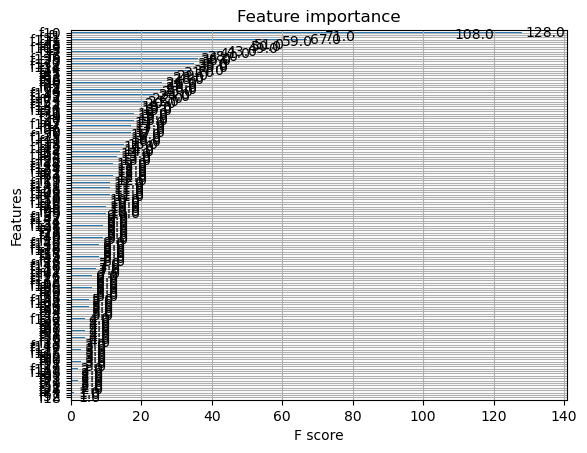

In [21]:
import matplotlib.pyplot as plt
xgb_model = pipe_tv.named_steps["xgb"]
xgb.plot_importance(xgb_model)
plt.show()


<Figure size 800x1000 with 0 Axes>

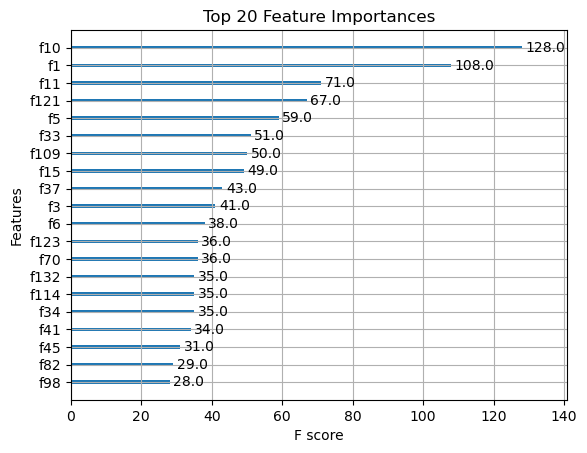

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))
plot_importance(xgb_model, max_num_features=20, importance_type="weight")  
plt.title("Top 20 Feature Importances")
plt.show()


<Figure size 800x1000 with 0 Axes>

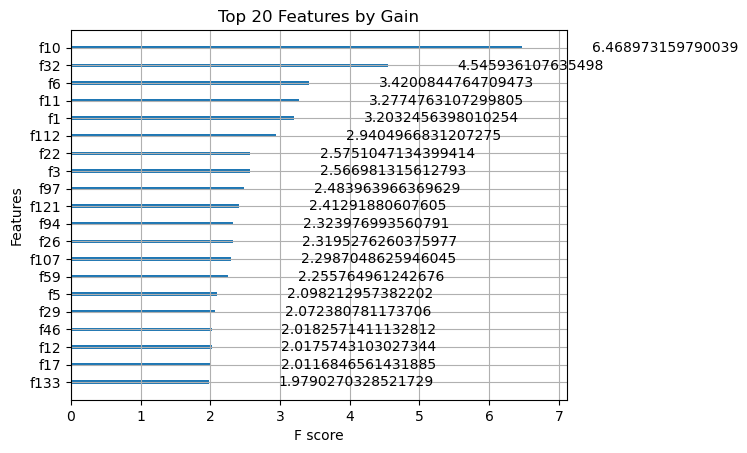

In [25]:
plt.figure(figsize=(8, 10))
plot_importance(xgb_model, max_num_features=20, importance_type="gain")
plt.title("Top 20 Features by Gain")
plt.show()


In [27]:
# Assume feat_names_tv is your list of original column names used for training
feature_map = {f"f{i}": name for i, name in enumerate(feat_names_tv)}


In [29]:
import pandas as pd

booster = xgb_model.get_booster()
importance = booster.get_score(importance_type="gain")

# Replace fN with actual feature names
importance_named = {feature_map.get(k, k): v for k, v in importance.items()}

imp_df = pd.DataFrame(
    sorted(importance_named.items(), key=lambda x: x[1], reverse=True),
    columns=["feature", "importance"]
)

print(imp_df.head(20))   # top 20 features with names


                 feature  importance
0          NM_global_p90    6.468973
1       QSM_label_11_p90    4.545936
2         NM_global_mean    3.420084
3          NM_global_std    3.277476
4            NM_SN_L_std    3.203246
5        QSM_label_5_p90    2.940497
6       QSM_label_10_min    2.575105
7            NM_SN_R_std    2.566981
8        QSM_label_3_std    2.483964
9        QSM_label_6_std    2.412919
10       QSM_label_3_min    2.323977
11  QSM_label_10_vol_mm3    2.319528
12       QSM_label_5_max    2.298705
13      QSM_label_15_max    2.255765
14         NM_global_max    2.098213
15   QSM_label_11_median    2.072381
16      QSM_label_13_min    2.018257
17        QSM_global_max    2.017574
18        QSM_global_p90    2.011685
19    QSM_label_8_median    1.979027


In [47]:
import pandas as pd

# Build a DataFrame so we can select by column names
X_tv_df = pd.DataFrame(X_tv, columns=feat_names_tv)

# Top-30 by gain (from your imp_df)
top_feats = imp_df["feature"].head(30).tolist()

# Keep only features that actually exist
top_feats_present = [f for f in top_feats if f in X_tv_df.columns]
missing = [f for f in top_feats if f not in X_tv_df.columns]
if missing:
    print("Skipping missing features:", missing)

X_tv_reduced = X_tv_df[top_feats_present].values  # back to ndarray for the pipeline
selected_feat_names = top_feats_present
print("Using", len(selected_feat_names), "features.")
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe_tv, X_tv, y_tv, cv=5, scoring="accuracy")
print(scores, scores.mean())

Using 30 features.
[0.73333333 0.68333333 0.83333333 0.73333333 0.81666667] 0.76


In [39]:
import pandas as pd

# Build a DataFrame so we can select by column names
X_tv_df = pd.DataFrame(X_tv, columns=feat_names_tv)

# Top-30 by gain (from your imp_df)
top_feats = imp_df["feature"].head(30).tolist()

# Keep only features that actually exist
top_feats_present = [f for f in top_feats if f in X_tv_df.columns]
missing = [f for f in top_feats if f not in X_tv_df.columns]
if missing:
    print("Skipping missing features:", missing)

X_tv_reduced = X_tv_df[top_feats_present].values  # back to ndarray for the pipeline
selected_feat_names = top_feats_present
print("Using", len(selected_feat_names), "features.")


Using 30 features.


Feature set size: (300, 157)
XGBoost: ROC AUC=0.858, ACC=0.800
RandomForest: ROC AUC=0.854, ACC=0.797


C:\Users\rubia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

LogReg_L1: ROC AUC=0.862, ACC=0.793

Best XGB params: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 400, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 1.0}
Best XGB CV ROC AUC: 0.8704444444444445
Tuned XGB CV Accuracy: 0.8266666666666665


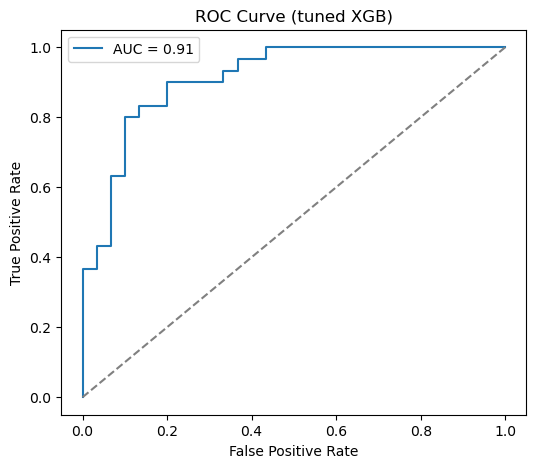

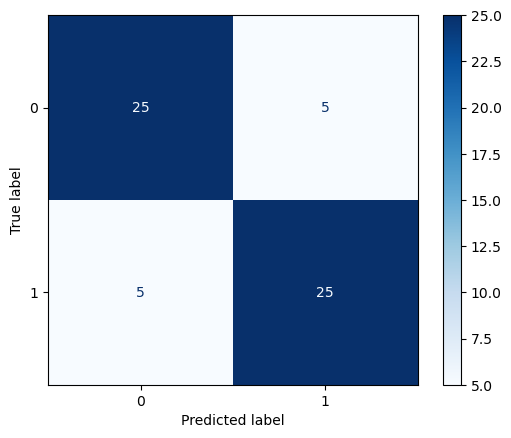

In [82]:
# ================================================================
# 1) Feature Engineering (asymmetry + ratios)
# ================================================================
import numpy as np

df_aug = pd.DataFrame(X_tv, columns=feat_names_tv)
df_aug["label"] = y_tv

# Example engineered features
if {"NM_SN_L_std", "NM_SN_R_std"}.issubset(df_aug.columns):
    df_aug["NM_SN_asym"] = (
        df_aug["NM_SN_L_std"] - df_aug["NM_SN_R_std"]
    ) / (df_aug["NM_SN_L_std"] + df_aug["NM_SN_R_std"] + 1e-6)

if {"NM_global_mean", "QSM_global_max"}.issubset(df_aug.columns):
    df_aug["NM_QSM_ratio"] = df_aug["NM_global_mean"] / (df_aug["QSM_global_max"] + 1e-6)

# Rebuild X, y with engineered features
X_eng = df_aug.drop(columns=["label"]).values
y_eng = df_aug["label"].values
feat_names_eng = df_aug.drop(columns=["label"]).columns.tolist()

print("Feature set size:", X_eng.shape)

# ================================================================
# 2) Models to Compare
# ================================================================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

pipe_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("xgb", xgb.XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8,
        reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", tree_method="hist",
        random_state=42, n_jobs=-1
    ))
])

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300, max_depth=8,
        random_state=42, n_jobs=-1
    ))
])

pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(
        penalty="l1", solver="saga",
        max_iter=5000, C=1.0,
        random_state=42
    ))
])

models = {
    "XGBoost": pipe_xgb,
    "RandomForest": pipe_rf,
    "LogReg_L1": pipe_lr
}

# ================================================================
# 3) CV Evaluation
# ================================================================
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    auc = cross_val_score(model, X_eng, y_eng, cv=cv, scoring="roc_auc")
    acc = cross_val_score(model, X_eng, y_eng, cv=cv, scoring="accuracy")
    results[name] = {"AUC": auc.mean(), "ACC": acc.mean()}
    print(f"{name}: ROC AUC={auc.mean():.3f}, ACC={acc.mean():.3f}")

# ================================================================
# 4) Hyperparameter Tuning for XGBoost
# ================================================================
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "xgb__n_estimators": [200, 400, 600, 800],
    "xgb__max_depth": [3, 4, 6, 8],
    "xgb__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "xgb__subsample": [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
    "xgb__reg_lambda": [0.1, 0.5, 1.0, 2.0],
    "xgb__reg_alpha": [0.0, 0.1, 0.5, 1.0]
}
search = RandomizedSearchCV(pipe_xgb, param_dist, n_iter=30, cv=cv,
                            scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_eng, y_eng)

print("\nBest XGB params:", search.best_params_)
print("Best XGB CV ROC AUC:", search.best_score_)

best_model = search.best_estimator_

# ================================================================
# 5) ROC & Confusion Matrix for tuned XGB
# ================================================================
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = cross_val_score(best_model, X_eng, y_eng, cv=cv, scoring="accuracy")
print("Tuned XGB CV Accuracy:", y_pred.mean())

# Single CV split for plotting
train_idx, test_idx = list(cv.split(X_eng, y_eng))[0]
best_model.fit(X_eng[train_idx], y_eng[train_idx])
y_proba = best_model.predict_proba(X_eng[test_idx])[:, 1]
y_pred = best_model.predict(X_eng[test_idx])

fpr, tpr, _ = roc_curve(y_eng[test_idx], y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (tuned XGB)")
plt.legend()
plt.show()

cm = confusion_matrix(y_eng[test_idx], y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.show()


In [ ]:
# ===========================================
# PHASE B: FINAL TRAIN+VAL FIT + TEST OUTPUT
# ===========================================
import numpy as np, pandas as pd, joblib
from pathlib import Path

OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path("./outputs")
tuned = joblib.load(OUT_DIR / "tuning_artifacts.pkl")
best_tuned_pipe = tuned["best_pipe"]    # has best params; currently fitted on TRAIN only
feat_cols       = tuned["feat_cols"]    # feature order from Phase A
best_t          = tuned["best_thresh"]  # tuned threshold from Phase A

# ---- Load TRAIN+VAL to refit full model with the same features
train_df = pd.read_csv(OUT_DIR / "features_train.csv")
val_df   = pd.read_csv(OUT_DIR / "features_val.csv")
for df in (train_df, val_df):
    df["subject_id"] = df["subject_id"].astype(str).str.strip()
assert "label" in train_df and "label" in val_df

trainval_df = pd.concat([train_df, val_df], ignore_index=True)

# Keep only Phase-A features (avoid leakage via accidental extra cols)
X_tv = trainval_df[feat_cols].apply(pd.to_numeric, errors="coerce").values
y_tv = trainval_df["label"].astype(int).values

# ---- Rebuild the same model structure with the best params, then fit on TRAIN+VAL
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

best_params = best_tuned_pipe.get_params()
# Extract only the XGB params from best_pipe for clarity
xgb_params = {k.replace("xgb__", ""): v for k, v in best_params.items() if k.startswith("xgb__")}

final_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=False)),
    ("xgb", xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="logloss",
        tree_method="hist", random_state=42, n_jobs=-1, **xgb_params
    ))
])

final_pipe.fit(X_tv, y_tv)

# ---- Save final model bundle (feature order included)
joblib.dump({"model": final_pipe, "features": feat_cols, "threshold": best_t},
            OUT_DIR / "xgb_trainval_final.pkl")
print("Saved final model:", OUT_DIR / "xgb_trainval_final.pkl")

# ---- TEST: load features, attach resnet_test if present, align columns, predict labels
test_df = pd.read_csv(OUT_DIR / "features_test.csv")
test_df["subject_id"] = test_df["subject_id"].astype(str).str.strip()

# If resnet_prob is missing and you have resnet_test.csv, merge it
if "resnet_prob" not in test_df.columns:
    rcsv = RESNET_TEST_CSV
    if rcsv.exists():
        rpred = pd.read_csv(rcsv)
        rpred["subject_id"] = rpred["subject_id"].astype(str).str.strip()
        if "resnet_prob" not in rpred.columns:
            raise ValueError(f"{rcsv} must have 'resnet_prob' column.")
        test_df = test_df.merge(rpred[["subject_id","resnet_prob"]], on="subject_id", how="left")
        print("[test] merged resnet_prob from resnet_test.csv")
    else:
        print("[test] resnet_prob absent; continuing without it (imputer will handle NaN).")

# Align to Phase-A feature list (add missing, drop extras, reorder)
for c in feat_cols:
    if c not in test_df.columns:
        test_df[c] = np.nan
extra = [c for c in test_df.columns if c not in feat_cols + ["subject_id"]]
if extra: test_df.drop(columns=extra, inplace=True)

X_te = test_df[feat_cols].apply(pd.to_numeric, errors="coerce").values

# Predict probabilities then apply tuned threshold from Phase A
te_proba = final_pipe.predict_proba(X_te)[:, 1]
te_pred  = (te_proba >= best_t).astype(int)

# ---- Build challenge submission: label_predict.csv (patient_id,prediction)
sub = pd.DataFrame({
    "patient_id": test_df["subject_id"],
    "prediction": te_pred
}).sort_values("patient_id").reset_index(drop=True)

save_path = OUT_DIR / "label_predict.csv"
sub.to_csv(save_path, index=False)
print(f"Saved submission CSV → {save_path}")
display(sub.head(10))
print("Total rows:", len(sub))


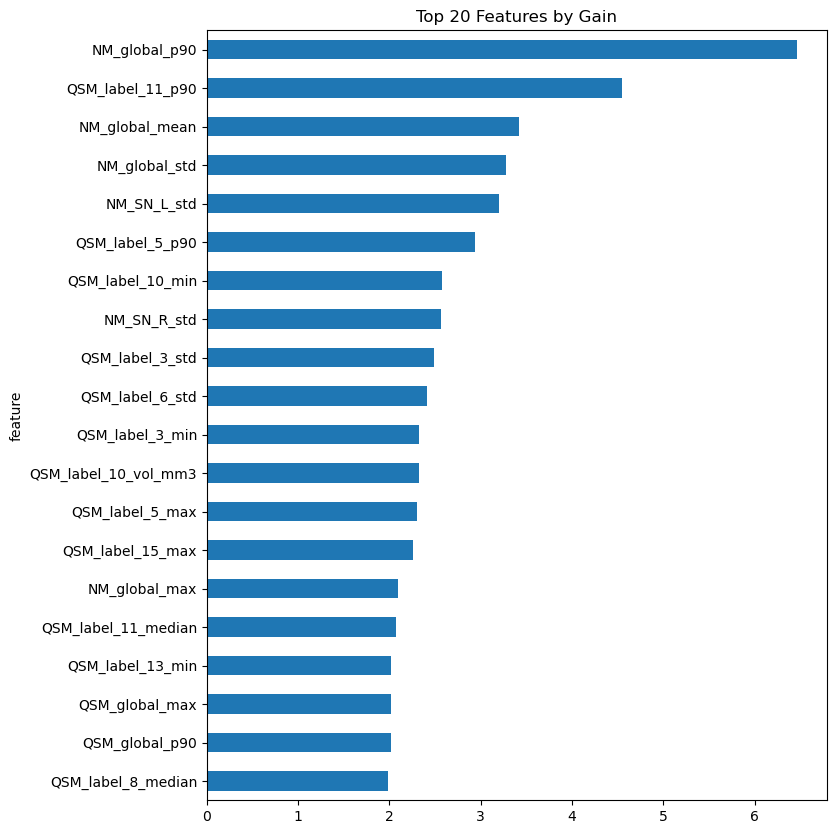

In [31]:
import matplotlib.pyplot as plt

topk = 20
imp_df.head(topk).plot(
    kind="barh", x="feature", y="importance",
    figsize=(8, 10), legend=False
)
plt.gca().invert_yaxis()  # most important on top
plt.title("Top 20 Features by Gain")
plt.show()


In [116]:
import numpy as np
import pandas as pd
from pathlib import Path

# Path to your ResNet test predictions
resnet_test_csv = Path(r"C:\Users\rubia\Downloads\cnn_preds\resnet_test.csv")

# Load test features
test_feats = pd.read_csv(OUT_DIR / "features_test.csv")
test_feats["subject_id"] = test_feats["subject_id"].astype(str).str.strip()

# If resnet_test.csv exists, load it; else create placeholder with NaNs
if resnet_test_csv.exists():
    resnet_preds = pd.read_csv(resnet_test_csv)
    resnet_preds["subject_id"] = resnet_preds["subject_id"].astype(str).str.strip()
    if "resnet_prob" not in resnet_preds.columns:
        raise ValueError(f"{resnet_test_csv} must contain a 'resnet_prob' column")
    print(f"[resnet] Loaded test preds: {resnet_preds.shape}")
else:
    # create placeholder with NaN values (so pipeline runs)
    resnet_preds = test_feats[["subject_id"]].copy()
    resnet_preds["resnet_prob"] = np.nan
    resnet_preds.to_csv(resnet_test_csv, index=False)
    print(f"[resnet] Test preds missing → created placeholder at {resnet_test_csv} (NaNs).")

# Merge into test_feats
test_feats = test_feats.merge(resnet_preds, on="subject_id", how="left")

print("test_feats shape after merge:", test_feats.shape)
display(test_feats.head())


[resnet] Loaded test preds: (200, 2)
test_feats shape after merge: (200, 23)


,subject_id,NM_global_max,NM_global_mean,NM_global_median,NM_global_min,NM_global_p10,NM_global_p90,NM_global_std,QSM_global_max,QSM_global_mean,...,QSM_global_p90,QSM_global_std,T1_global_max,T1_global_mean,T1_global_median,T1_global_min,T1_global_p10,T1_global_p90,T1_global_std,resnet_prob
0,RJPD_003,67624.828125,6186.791016,1571.510376,2.011790e-18,24.944609,17236.724609,7240.848145,630.995300,0.223251,...,32.152991,30.215086,93942.148438,6196.562012,2501.471680,7.959948e-09,12.001292,15991.839844,6791.064941,NaN
1,RJPD_007,48705.339844,6765.746094,3045.559326,2.231236e-17,23.608986,16431.853516,7052.893066,671.100830,-0.263600,...,30.304605,33.608772,96903.531250,6504.437988,3645.344971,1.262752e-12,19.791339,15512.215039,6660.333496,NaN
2,RJPD_009,56466.601562,7105.549316,4196.142090,4.493300e-17,51.804127,16525.541016,6910.301758,2840.884521,-0.253355,...,31.578489,41.429848,91597.320312,7042.165527,6682.293945,5.812525e-09,28.918749,15284.092773,6381.591797,NaN
3,RJPD_014,54378.046875,6325.741699,1927.261353,4.231982e-17,24.395714,16564.689453,7007.877441,518.025391,0.079843,...,31.698462,33.272015,96117.710938,5949.735352,2376.241699,1.718912e-10,12.027765,15345.368945,6455.636230,NaN
4,RJPD_015,65061.019531,7670.664551,5414.879883,7.152273e-17,54.973400,16876.833984,7151.840820,945.127075,0.104248,...,31.252563,33.203583,117430.054688,7429.908691,7485.328125,3.530808e-08,38.390123,15728.850879,6548.105469,NaN


# GO TO THE LEAK PROOF PIPELINE 

# --- Discover test subjects and build `test_merged` features ---
from pathlib import Path
import pandas as pd

# If you already have SPLIT_DIRS["test"] set up, this will use it.
# Otherwise, set TEST_DIR manually, e.g.:
TEST_DIR = r"test"

if 'SPLIT_DIRS' in globals() and isinstance(SPLIT_DIRS, dict) and 'test' in SPLIT_DIRS and Path(SPLIT_DIRS['test']).exists():
    test_dir = Path(SPLIT_DIRS['test'])
elif 'TEST_DIR' in globals() and TEST_DIR:
    test_dir = Path(TEST_DIR)
else:
    raise FileNotFoundError("Couldn't find test dir. Set SPLIT_DIRS['test'] or define TEST_DIR = 'path/to/test'.")

# RJPD_* subfolders inside test/
test_ids = sorted([p.name for p in test_dir.iterdir() if p.is_dir()])
test_df  = pd.DataFrame({"subject_id": test_ids})

# Build features for test split (uses your existing functions)
if 'build_features_for_split' not in globals():
    raise RuntimeError("`build_features_for_split` not found. Run the cell where it is defined.")

test_feats = build_features_for_split("test", test_df) if len(test_ids) else pd.DataFrame()

# (optional) merge ResNet test probabilities if you have them
if 'attach_resnet' in globals() and callable(attach_resnet) and not test_feats.empty:
    test_feats = attach_resnet(test_feats, "test")

# Keep as test_merged (no labels for test)
test_merged = test_feats.copy()

# Peek
try:
    display(test_merged.head())
except:
    print(test_merged.head())
print(f"Discovered {len(test_ids)} subjects; test_merged shape = {test_merged.shape}")


In [86]:
import joblib

bundle = joblib.load(OUT_DIR / "xgb_trainval.pkl")  # or xgb_trainval_stacked.pkl if you made one
feat_names = bundle["features"]

print("Number of features in model:", len(feat_names))
print("First 10 features:", feat_names[:10])
print("'resnet_prob' in features?", "resnet_prob" in feat_names)


Number of features in model: 155
First 10 features: ['NM_SN_L_mean', 'NM_SN_L_std', 'NM_SN_R_mean', 'NM_SN_R_std', 'NM_SN_total_vol_mm3', 'NM_global_max', 'NM_global_mean', 'NM_global_median', 'NM_global_min', 'NM_global_p10']
'resnet_prob' in features? True


In [88]:
import numpy as np, pandas as pd, joblib

# 1) Load trained model + feature order
bundle = joblib.load(OUT_DIR / "xgb_trainval.pkl")   # or ..._stacked.pkl if you saved a separate one
pipe_tv = bundle["model"]
feat_names = bundle["features"]   # includes 'resnet_prob'

# 2) Load test features and (already) merged resnet_prob
test_feats = pd.read_csv(OUT_DIR / "features_test.csv")
test_feats["subject_id"] = test_feats["subject_id"].astype(str).str.strip()

# If you just merged resnet_prob earlier:
# test_feats = test_feats.merge(resnet_preds, on="subject_id", how="left")

# 3) Align to training columns: add missing, drop extras, reorder
X_te_df = test_feats.copy()
for c in feat_names:
    if c not in X_te_df.columns:
        X_te_df[c] = np.nan
extra = [c for c in X_te_df.columns if c not in feat_names + ["subject_id"]]
if extra:
    X_te_df.drop(columns=extra, inplace=True)
X_te_df = X_te_df[feat_names].apply(pd.to_numeric, errors="coerce")

# 4) Predict probabilities
pd_proba = pipe_tv.predict_proba(X_te_df.values)[:, 1]

# 5) Save
out = pd.DataFrame({"subject_id": test_feats["subject_id"], "pd_proba": pd_proba})
out_path = OUT_DIR / "stacked_test_predictions.csv"
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Saved: C:\Users\rubia\Downloads\out\stacked_test_predictions.csv


C:\Users\rubia\AppData\Local\Temp\ipykernel_41144\1406318221.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_te_df[c] = np.nan
C:\Users\rubia\AppData\Local\Temp\ipykernel_41144\1406318221.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_te_df[c] = np.nan
C:\Users\rubia\AppData\Local\Temp\ipykernel_41144\1406318221.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [90]:
# Show first 10 predicted test cases
print(out.head(10))


  subject_id  pd_proba
0   RJPD_003  0.079189
1   RJPD_007  0.003526
2   RJPD_009  0.007205
3   RJPD_014  0.002956
4   RJPD_015  0.149365
5   RJPD_020  0.761885
6   RJPD_021  0.980127
7   RJPD_025  0.006084
8   RJPD_026  0.976470
9   RJPD_030  0.821200


In [100]:
import pandas as pd
from pathlib import Path

# Paths
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path("./outputs")
TRAIN_CASES_CSV = Path("train_cases (2).csv")  # adjust path if needed
VAL_CASES_CSV   = Path("val_cases (2).csv")    # adjust path if needed



# Helper: load a cases CSV and normalize columns to subject_id + label
def load_cases_normalized(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # detect id column
    id_candidates = ["subject_id", "id", "patient_id", "case_id"]
    id_col = next((c for c in id_candidates if c in df.columns), None)
    if id_col is None:
        raise KeyError(f"No ID column found in {path}. Expected one of: {id_candidates}")
    # detect label column
    label_candidates = ["label", "Label", "y", "target", "class"]
    label_col = next((c for c in label_candidates if c in df.columns), None)
    if label_col is None:
        raise KeyError(f"No label column found in {path}. Expected one of: {label_candidates}")

    df = df[[id_col, label_col]].copy()
    df.rename(columns={id_col: "subject_id", label_col: "label"}, inplace=True)
    df["subject_id"] = df["subject_id"].astype(str).str.strip()
    # try to coerce label to int (0/1)
    df["label"] = pd.to_numeric(df["label"], errors="coerce")
    # If label isn't 0/1 exactly, try mapping strings
    if df["label"].isna().any():
        map_lower = {"pd": 1, "hc": 0, "control": 0, "case": 1, "positive": 1, "negative": 0}
        if df[label_col].dtype == object:
            df["label"] = df[label_col].astype(str).str.lower().map(map_lower)
    df["label"] = df["label"].astype(int)
    return df

# Load feature files
train_feats = pd.read_csv(OUT_DIR / "features_train.csv")
val_feats   = pd.read_csv(OUT_DIR / "features_val.csv")

# Normalize subject_id in features
for d in (train_feats, val_feats):
    if "subject_id" not in d.columns:
        raise KeyError("Features file missing 'subject_id' column.")
    d["subject_id"] = d["subject_id"].astype(str).str.strip()

# Load & normalize case lists
train_cases = load_cases_normalized(TRAIN_CASES_CSV)
val_cases   = load_cases_normalized(VAL_CASES_CSV)

# Merge labels back
before_train_has_label = "label" in train_feats.columns
before_val_has_label   = "label" in val_feats.columns

train_feats = train_feats.merge(train_cases, on="subject_id", how="left")
val_feats   = val_feats.merge(val_cases,   on="subject_id", how="left")

# Quick checks
missing_train = train_feats["label"].isna().sum()
missing_val   = val_feats["label"].isna().sum()
print(f"train_feats rows: {len(train_feats)} | labels missing after merge: {missing_train}")
print(f"val_feats rows:   {len(val_feats)}   | labels missing after merge: {missing_val}")
if missing_train or missing_val:
    print("⚠️ Some labels are missing after merge. Check for ID mismatches (whitespace/case).")

# Save back
train_feats.to_csv(OUT_DIR / "features_train.csv", index=False)
val_feats.to_csv(OUT_DIR / "features_val.csv", index=False)

print("Saved updated features with labels.")
display(val_feats.head(10))


train_feats rows: 200 | labels missing after merge: 0
val_feats rows:   100   | labels missing after merge: 0
Saved updated features with labels.


,subject_id,NM_SN_L_mean,NM_SN_L_std,NM_SN_R_mean,NM_SN_R_std,NM_SN_total_vol_mm3,NM_global_max,NM_global_mean,NM_global_median,NM_global_min,...,QSM_label_9_std,QSM_label_9_vol_mm3,T1_global_max,T1_global_mean,T1_global_median,T1_global_min,T1_global_p10,T1_global_p90,T1_global_std,label
0,RJPD_002,22850.023438,1104.293091,22784.218750,1081.220703,618.666704,62316.578125,6787.802246,2204.967529,9.107165e-17,...,41.271198,78.222227,107552.265625,6621.784180,2740.697754,7.067781e-09,17.891146,16856.750000,7154.997559,0
1,RJPD_211,18889.458984,952.028564,19354.324219,1018.885498,556.444478,55135.203125,6447.500977,2831.137451,4.162068e-17,...,67.606819,45.333336,87913.210938,6247.491211,4146.522949,1.915407e-09,13.285792,14969.111133,6377.717285,0
2,RJPD_220,21551.287109,765.662231,21462.470703,849.267822,542.222255,63629.265625,7161.236328,2565.929443,1.000265e-16,...,39.851604,60.444448,104499.531250,6915.990723,3616.412842,1.685394e-08,20.199064,16683.232812,7138.838379,0
3,RJPD_035,21456.898438,1024.854858,21209.886719,1034.936646,683.555596,67193.296875,6382.616211,1563.262207,4.310792e-17,...,40.123276,41.777780,117708.773438,6309.306641,2560.039795,1.240387e-10,10.179655,16438.841406,7076.401855,0
4,RJPD_219,20019.896484,1002.282532,19808.015625,1025.015259,655.111150,53041.542969,6340.012207,2573.642334,4.251960e-17,...,43.527733,74.666671,95728.812500,6688.616211,3816.311523,2.094471e-08,22.416431,15714.796875,6853.771973,0
5,RJPD_248,21111.669922,967.019470,20693.396484,939.506409,617.777815,61301.394531,7317.242676,3314.262451,8.645607e-17,...,40.108028,39.111113,97761.585938,7001.701660,4277.463867,1.787036e-10,15.937457,16694.726562,7087.484375,0
6,RJPD_301,19854.150391,725.315063,20028.457031,794.273499,506.666697,57503.281250,6349.494629,2761.856934,2.256706e-18,...,49.286358,26.666668,87413.585938,6466.016602,4240.068848,3.967693e-06,16.644951,15227.598633,6539.290039,0
7,RJPD_011,20477.986328,1039.742065,19514.892578,975.819214,583.111146,59831.039062,5853.950195,1404.600220,2.823501e-17,...,41.170517,49.777781,97235.414062,5725.674805,1247.362061,1.483462e-09,11.344432,15763.852051,6647.639648,0
8,RJPD_309,18755.576172,1005.920349,19356.759766,1186.348877,531.555587,51579.027344,6145.795898,2047.160645,4.081905e-17,...,31.685413,35.555558,97095.390625,6023.969238,2153.166992,6.542974e-09,16.870662,15203.476953,6575.166504,0
9,RJPD_295,20663.828125,1032.636719,20728.238281,949.603638,564.444478,55279.164062,8233.488281,6529.033691,1.887678e-16,...,48.356407,56.000003,97955.937500,8089.956543,8351.586914,4.000917e-09,33.930946,16440.693750,6801.212402,0


## NO NEED

In [104]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix

# -------------------------
# Config
# -------------------------
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path("./outputs")
MODEL_PATH = OUT_DIR / "xgb_trainval.pkl"            # trained with resnet_prob
VAL_CSV    = OUT_DIR / "features_val.csv"            # must include 'label'
TEST_CSV   = OUT_DIR / "features_test.csv"
RESNET_TEST_CSV = Path(r"C:\Users\rubia\Downloads\cnn_preds\resnet_test.csv")  # used only if test lacks resnet_prob

# -------------------------
# Load model + feature list
# -------------------------
bundle = joblib.load(MODEL_PATH)
pipe_tv   = bundle["model"]
feat_list = bundle["features"]  # exact order used in training (includes 'resnet_prob')

# -------------------------
# Load validation features (with labels)
# -------------------------
val_df = pd.read_csv(VAL_CSV)
if "subject_id" in val_df:
    val_df["subject_id"] = val_df["subject_id"].astype(str).str.strip()
if "label" not in val_df.columns:
    raise ValueError("features_val.csv must include a 'label' column for threshold tuning.")

# Ensure resnet_prob exists for val (if your pipeline already merged it, this is a no-op)
if "resnet_prob" not in val_df.columns:
    print("[val] 'resnet_prob' not found in features_val.csv. "
          "If you trained with resnet_prob, please merge it for val as well.")
# Align columns for validation
val_work = val_df.copy()
for c in feat_list:
    if c not in val_work.columns:
        val_work[c] = np.nan
# Drop extras (keep id/label separately)
extra_cols = [c for c in val_work.columns if c not in feat_list + ["subject_id","label"]]
if extra_cols:
    val_work.drop(columns=extra_cols, inplace=True)
X_val = val_work[feat_list].apply(pd.to_numeric, errors="coerce").values
y_val = val_work["label"].astype(int).values

# -------------------------
# Load test features (+resnet_prob if needed)
# -------------------------
test_df = pd.read_csv(TEST_CSV)
test_df["subject_id"] = test_df["subject_id"].astype(str).str.strip()

if "resnet_prob" not in test_df.columns:
    # Try to merge it from resnet_test.csv
    if RESNET_TEST_CSV.exists():
        rpred = pd.read_csv(RESNET_TEST_CSV)
        rpred["subject_id"] = rpred["subject_id"].astype(str).str.strip()
        if "resnet_prob" not in rpred.columns:
            raise ValueError(f"{RESNET_TEST_CSV} must contain a 'resnet_prob' column.")
        test_df = test_df.merge(rpred[["subject_id","resnet_prob"]], on="subject_id", how="left")
        print("[test] merged resnet_prob from resnet_test.csv")
    else:
        print("[test] WARNING: resnet_test.csv not found and 'resnet_prob' absent; proceeding without it (imputer will fill NaN).")

# Align columns for test
test_work = test_df.copy()
for c in feat_list:
    if c not in test_work.columns:
        test_work[c] = np.nan
extra_cols = [c for c in test_work.columns if c not in feat_list + ["subject_id"]]
if extra_cols:
    test_work.drop(columns=extra_cols, inplace=True)
X_test = test_work[feat_list].apply(pd.to_numeric, errors="coerce").values

# -------------------------
# Get validation probabilities
# -------------------------
val_proba = pipe_tv.predict_proba(X_val)[:, 1]

# -------------------------
# Tune threshold on validation (maximize accuracy)
# -------------------------
thresholds = np.linspace(0.0, 1.0, 1001)
accs = []
for t in thresholds:
    accs.append(accuracy_score(y_val, (val_proba >= t).astype(int)))
accs = np.array(accs)
best_idx = accs.argmax()
best_t = float(thresholds[best_idx])
best_acc = float(accs[best_idx])

# Optional: show confusion matrix at best threshold
y_val_pred = (val_proba >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
sens = tp / (tp + fn) if (tp + fn) else 0.0
spec = tn / (tn + fp) if (tn + fp) else 0.0

print(f"Best threshold (val): {best_t:.3f} | Val Accuracy: {best_acc:.3f} | Sensitivity: {sens:.3f} | Specificity: {spec:.3f}")

# -------------------------
# Predict on test with tuned threshold
# -------------------------
test_proba = pipe_tv.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= best_t).astype(int)

# -------------------------
# Build submission CSV as required by the challenge
# Columns: patient_id, prediction (0/1)
# -------------------------
sub = pd.DataFrame({
    "patient_id": test_df["subject_id"],
    "prediction": test_pred
}).sort_values("patient_id").reset_index(drop=True)

save_path = OUT_DIR / "label_predict.csv"
sub.to_csv(save_path, index=False)
print(f"Saved submission CSV → {save_path}")
display(sub.head(10))
print("Total rows:", len(sub))



[val] 'resnet_prob' not found in features_val.csv. If you trained with resnet_prob, please merge it for val as well.
[test] merged resnet_prob from resnet_test.csv


C:\Users\rubia\AppData\Local\Temp\ipykernel_41144\3852489964.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_work[c] = np.nan
C:\Users\rubia\AppData\Local\Temp\ipykernel_41144\3852489964.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_work[c] = np.nan
C:\Users\rubia\AppData\Local\Temp\ipykernel_41144\3852489964.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

Best threshold (val): 0.064 | Val Accuracy: 1.000 | Sensitivity: 1.000 | Specificity: 1.000
Saved submission CSV → C:\Users\rubia\Downloads\out\label_predict.csv


,patient_id,prediction
0,RJPD_003,1
1,RJPD_007,0
2,RJPD_009,0
3,RJPD_014,0
4,RJPD_015,1
5,RJPD_020,1
6,RJPD_021,1
7,RJPD_025,0
8,RJPD_026,1
9,RJPD_030,1


Total rows: 200


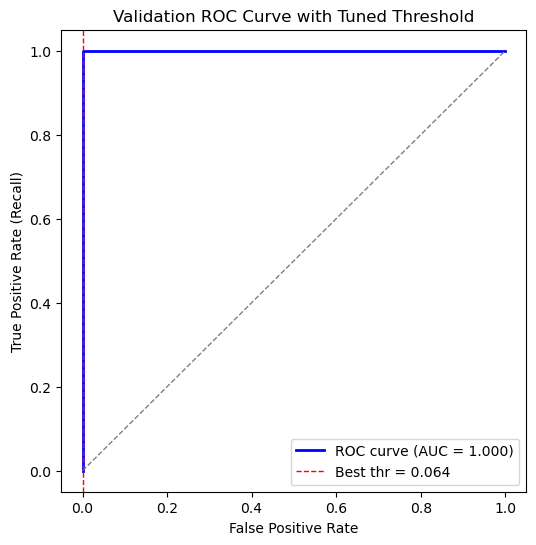

Validation set size: 100
Predicted PD (>= 0.064): 50
Predicted HC (< 0.064): 50


In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve & AUC for validation
fpr, tpr, thr = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="gray", lw=1, linestyle="--")

# Mark the tuned threshold
plt.axvline(x=(1 - sens), color="red", linestyle="--", lw=1, label=f"Best thr = {best_t:.3f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Validation ROC Curve with Tuned Threshold")
plt.legend(loc="lower right")
plt.show()

# Show distribution of predictions relative to threshold
n_pos = (val_proba >= best_t).sum()
n_neg = (val_proba < best_t).sum()
print(f"Validation set size: {len(val_proba)}")
print(f"Predicted PD (>= {best_t:.3f}): {n_pos}")
print(f"Predicted HC (< {best_t:.3f}): {n_neg}")


In [112]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load ground-truth validation cases
val_cases = pd.read_csv("val_cases (2).csv")
val_cases["id"] = val_cases["id"].astype(str).str.strip()

# Load your validation predictions (from val_proba)
val_pred_df = pd.DataFrame({
    "id": val_work["subject_id"],   # the same IDs you used in validation features
    "proba": val_proba
})

# Merge GT + predictions
merged_val = val_cases.merge(val_pred_df, on="id", how="left")

# Apply best threshold (from your tuning step)
merged_val["pred"] = (merged_val["proba"] >= best_t).astype(int)

# Metrics
y_true = merged_val["label"].astype(int).values
y_pred = merged_val["pred"].values
y_proba = merged_val["proba"].values

print("Classification report (val, tuned threshold):")
print(classification_report(y_true, y_pred, digits=3))

print("Confusion matrix (val, tuned threshold):")
print(confusion_matrix(y_true, y_pred))

print("ROC AUC (val):", roc_auc_score(y_true, y_proba))

# Show first 10 rows
display(merged_val.head(10))


Classification report (val, tuned threshold):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        50

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100

Confusion matrix (val, tuned threshold):
[[50  0]
 [ 0 50]]
ROC AUC (val): 1.0


,id,label,proba,pred
0,RJPD_002,0,0.023212,0
1,RJPD_211,0,0.005923,0
2,RJPD_220,0,0.046924,0
3,RJPD_035,0,0.012791,0
4,RJPD_219,0,0.000415,0
5,RJPD_248,0,0.019231,0
6,RJPD_301,0,0.012013,0
7,RJPD_011,0,0.006051,0
8,RJPD_309,0,0.003689,0
9,RJPD_295,0,0.028800,0


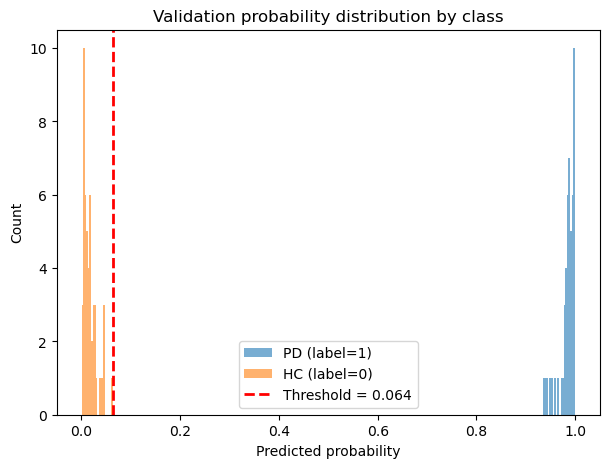

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(val_proba[y_val==1], bins=20, alpha=0.6, label="PD (label=1)")
plt.hist(val_proba[y_val==0], bins=20, alpha=0.6, label="HC (label=0)")
plt.axvline(best_t, color="red", linestyle="--", lw=2, label=f"Threshold = {best_t:.3f}")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Validation probability distribution by class")
plt.legend()
plt.show()


In [ ]:
# --- Cell 1: load data + detect NM/QSM columns and label (robust) ---
import re, numpy as np, pandas as pd

# Set your file path here
DATA_CSV = r"C:\Users\rubia\Downloads\out\features_train.csv"  # or r"/mnt/data/features_train.csv"

# OPTIONAL: if you know the exact label column name, set it here (e.g., "diagnosis" / "Group")
# LABEL_COL_OVERRIDE = "diagnosis"

df_regions = pd.read_csv(DATA_CSV)
print("Loaded:", DATA_CSV, "shape=", df_regions.shape)

# ------------- Detect label column -------------
def coerce_to_binary(s):
    """Try to coerce a Series to {0,1} with sensible mappings."""
    if np.issubdtype(s.dtype, np.number):
        # numeric -> map min->0, max->1 if exactly 2 unique (excluding NaN)
        vals = pd.unique(s.dropna())
        if len(vals) == 2:
            lo, hi = np.sort(vals)[:2]
            return s.map(lambda v: 0 if v==lo else (1 if v==hi else np.nan)).astype("float")
        return pd.to_numeric(s, errors="coerce")
    # string/categorical
    m = {"hc":0,"control":0,"c":0,"healthy":0,"0":0,
         "pd":1,"patient":1,"p":1,"case":1,"1":1}
    return s.astype(str).str.strip().str.lower().map(m)

label_col = None
y = None

# 1) Manual override
if "LABEL_COL_OVERRIDE" in globals() and LABEL_COL_OVERRIDE in df_regions.columns:
    label_col = LABEL_COL_OVERRIDE
    y = coerce_to_binary(df_regions[label_col])

# 2) Common names
if y is None or y.isna().all():
    for cand in ["label","PD","pd","target","y","diagnosis","dx","group","Group","class","status","is_pd","pd_label","condition","outcome"]:
        if cand in df_regions.columns:
            yc = coerce_to_binary(df_regions[cand])
            if yc.notna().sum() >= len(df_regions)*0.9:  # mostly valid
                label_col = cand
                y = yc
                break

# 3) Any binary-looking column (skip obvious region feature columns)
if y is None or y.isna().all():
    region_like = re.compile(r"(?i)\b(?:nm|qsm)\s*[_\-\s]?\s*\d{1,2}\b")
    for col in df_regions.columns:
        if region_like.search(str(col)):  # skip feature columns
            continue
        vals = pd.unique(df_regions[col].dropna())
        if len(vals) == 2:
            yc = coerce_to_binary(df_regions[col])
            if yc.notna().sum() >= len(df_regions)*0.9:
                label_col = col
                y = yc
                break

if y is not None:
    y = y.fillna(0).astype(int)
    df_regions["__PD__"] = y
    print(f"Label detected → using column: {label_col} (stored as __PD__)")
else:
    print("No label column detected. Visuals will be generated without PD split.")

# ------------- Detect NM/QSM region columns (1..16) -------------
def find_region_columns(df, tag="NM"):
    out = {}
    pat = re.compile(rf"(?i)\b{tag}\s*[_\-\s]?\s*(\d{{1,2}})\b")
    for col in df.columns:
        m = pat.search(str(col))
        if m:
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in out:
                out[idx] = col
    if not out:
        # loose fallback: any column containing tag + a number
        for col in df.columns:
            if tag.lower() in str(col).lower():
                m2 = re.search(r"(\d{1,2})", str(col))
                if m2:
                    idx = int(m2.group(1))
                    if 1 <= idx <= 16 and idx not in out:
                        out[idx] = col
    missing = [i for i in range(1,17) if i not in out]
    if missing:
        print(f"Warning: missing {tag} columns for indices: {missing}")
    return [out[i] for i in range(1,17) if i in out]

NM_cols  = find_region_columns(df_regions, "NM")
QSM_cols = find_region_columns(df_regions, "QSM")

print(f"Detected NM columns ({len(NM_cols)}):", NM_cols[:6], "..." if len(NM_cols)>6 else "")
print(f"Detected QSM columns({len(QSM_cols)}):", QSM_cols[:6], "..." if len(QSM_cols)>6 else "")


# --- Cell 2: summaries (PD split if available) and save CSV ---
import pandas as pd
import numpy as np

def group_means(df, cols, ycol="__PD__"):
    if not cols: return None
    if ycol in df.columns:
        means0 = df.loc[df[ycol]==0, cols].mean(numeric_only=True)
        means1 = df.loc[df[ycol]==1, cols].mean(numeric_only=True)
        reg_idx = [int(''.join(filter(str.isdigit, c))) for c in cols]
        out = pd.DataFrame({
            "region": reg_idx,
            "mean_PD0": means0.values,
            "mean_PD1": means1.values
        }).sort_values("region")
        out["delta_PD1_minus_PD0"] = out["mean_PD1"] - out["mean_PD0"]
        return out.reset_index(drop=True)
    else:
        means = df[cols].mean(numeric_only=True)
        reg_idx = [int(''.join(filter(str.isdigit, c))) for c in cols]
        out = pd.DataFrame({
            "region": reg_idx,
            "overall_mean": means.values
        }).sort_values("region").reset_index(drop=True)
        return out

nm_summary  = group_means(df_regions, NM_cols)
qsm_summary = group_means(df_regions, QSM_cols)

# merge for a single export
frames = []
if nm_summary is not None:
    nm = nm_summary.copy(); nm["modality"] = "NM"; frames.append(nm)
if qsm_summary is not None:
    qs = qsm_summary.copy(); qs["modality"] = "QSM"; frames.append(qs)
summary_all = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
summary_all.to_csv("region_means_nm_qsm.csv", index=False)
print("Saved region_means_nm_qsm.csv")
summary_all.head()


# Shim for display_dataframe_to_user so the rest of the code works unchanged
try:
    from IPython.display import display as _display
except Exception:
    _display = None

def display_dataframe_to_user(name, df):
    print(f"\n=== {name} ===")
    if _display is not None:
        _display(df)
    else:
        # Fallback for non-notebook environments
        print(df.to_string(index=False))


# Load your uploaded CSVs, merge labels into features, and generate PD vs HC visuals.
# - Reads: /mnt/data/features_train.csv (features) and /mnt/data/train_cases.csv (labels)
# - Auto-detects join keys and label column, coerces to {0,1}
# - Builds NM/QSM region summaries (1..16), then plots PD=0 vs PD=1 grouped bars, slopes, and heatmaps
# - Saves figures and a summary CSV for download
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

feat_path = Path("C:/Users/rubia/Downloads/out/features_train.csv")
cases_path = Path("train_cases.csv")

assert feat_path.exists(), f"Missing {feat_path}"
assert cases_path.exists(), f"Missing {cases_path}"

df_feat = pd.read_csv(feat_path)
df_cases = pd.read_csv(cases_path)

# --- Helper: find a likely join key ---
def find_key(df):
    cand_keys = ["subject_id","Subject_ID","SUBJECT_ID","subject","Subject","id","ID","case_id","CaseID","case","Case"]
    for c in cand_keys:
        if c in df.columns:
            return c
    # fallback: a column that looks like 'RJPD_XXX' or alphanumeric IDs
    for c in df.columns:
        ser = df[c].astype(str)
        if ser.str.match(r"(?i)r?j?pd[_\-]?\d+").any():
            return c
    return None

k_feat = find_key(df_feat)
k_case = find_key(df_cases)

# If no explicit key, try to synthesize 'subject_id' from index (last resort)
if k_feat is None:
    df_feat = df_feat.reset_index().rename(columns={"index":"subject_id"})
    k_feat = "subject_id"

if k_case is None:
    df_cases = df_cases.reset_index().rename(columns={"index":"subject_id"})
    k_case = "subject_id"

# --- Helper: detect/convert label column to {0,1} ---
def coerce_to_binary_col(df):
    # Try common names
    for cand in ["label","PD","pd","target","y","diagnosis","dx","group","Group","class","status","is_pd","pd_label","condition","outcome"]:
        if cand in df.columns:
            s = df[cand]
            # numeric
            if np.issubdtype(s.dtype, np.number):
                vals = pd.unique(s.dropna())
                if len(vals) == 2:
                    lo, hi = np.sort(vals)[:2]
                    return (s == hi).astype(int), cand
                # non-binary numeric -> map min/max as 0/1 if only two unique after rounding
                return pd.to_numeric(s, errors="coerce").fillna(0).clip(0,1).astype(int), cand
            # string/categorical
            m = {"hc":0,"control":0,"c":0,"healthy":0,"0":0,
                 "pd":1,"patient":1,"p":1,"case":1,"1":1}
            return s.astype(str).str.strip().str.lower().map(m).fillna(0).astype(int), cand
    # Otherwise, search any binary-looking column excluding region columns
    region_like = re.compile(r"(?i)\b(?:nm|qsm)\s*[_\-\s]?\s*\d{1,2}\b")
    for c in df.columns:
        if region_like.search(str(c)):
            continue
        vals = pd.unique(df[c].dropna())
        if len(vals) == 2:
            s = df[c]
            if np.issubdtype(s.dtype, np.number):
                lo, hi = np.sort(vals)[:2]
                return (s == hi).astype(int), c
            else:
                m = {"hc":0,"control":0,"c":0,"healthy":0,"0":0,
                     "pd":1,"patient":1,"p":1,"case":1,"1":1}
                return s.astype(str).str.strip().str.lower().map(m).fillna(0).astype(int), c
    return None, None

y_bin, y_col = coerce_to_binary_col(df_cases)
if y_bin is None:
    raise RuntimeError("Could not detect binary PD/HC label in train_cases.csv. Please add a label column (e.g., 'label' 0/1).")
df_cases = df_cases.copy()
df_cases["__PD__"] = y_bin

# --- Merge features with labels ---
dfm = df_feat.merge(df_cases[[k_case,"__PD__"]], left_on=k_feat, right_on=k_case, how="inner")
if "__PD__" not in dfm.columns or len(dfm) == 0:
    raise RuntimeError("Merge produced no rows with labels. Check that subject IDs/keys match between the two CSVs.")

# Show a preview
display_dataframe_to_user("Merged features + labels (head)", dfm.head(20))

# --- Find NM_* and QSM_* region columns ---
def find_region_columns(df, tag="NM"):
    out = {}
    pat = re.compile(rf"(?i)\b{tag}\s*[_\-\s]?(\d{{1,2}})\b")
    for col in df.columns:
        m = pat.search(str(col))
        if m:
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in out:
                out[idx] = col
    # loose fallback
    if not out:
        for col in df.columns:
            if tag.lower() in str(col).lower():
                m2 = re.search(r"(\d{1,2})", str(col))
                if m2:
                    idx = int(m2.group(1))
                    if 1 <= idx <= 16 and idx not in out:
                        out[idx] = col
    return [out[i] for i in range(1,17) if i in out]

NM_cols  = find_region_columns(dfm, "NM")
QSM_cols = find_region_columns(dfm, "QSM")

# --- Summaries ---
def group_means(df, cols, ycol="__PD__"):
    if not cols: return None
    means0 = df.loc[df[ycol]==0, cols].mean(numeric_only=True)
    means1 = df.loc[df[ycol]==1, cols].mean(numeric_only=True)
    reg_idx = [int(''.join(filter(str.isdigit, c))) for c in cols]
    out = pd.DataFrame({
        "region": reg_idx,
        "mean_PD0": means0.values,
        "mean_PD1": means1.values
    }).sort_values("region")
    out["delta_PD1_minus_PD0"] = out["mean_PD1"] - out["mean_PD0"]
    return out.reset_index(drop=True)

nm_summary  = group_means(dfm, NM_cols) if NM_cols else None
qsm_summary = group_means(dfm, QSM_cols) if QSM_cols else None

# --- Plotters (matplotlib only, one figure each) ---
def plot_grouped_bars(df_mod, title, outfile, xtick_labels=None):
    import numpy as np
    if df_mod is None or df_mod.empty:
        return None
    x = np.arange(len(df_mod["region"]))
    w = 0.4
    plt.figure()
    plt.bar(x - w/2, df_mod["mean_PD0"], width=w, label="PD=0")
    plt.bar(x + w/2, df_mod["mean_PD1"], width=w, label="PD=1")
    plt.xticks(x, xtick_labels if xtick_labels is not None else df_mod["region"].astype(int), rotation=45, ha="right")
    plt.xlabel("Region")
    plt.ylabel("Mean value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    return str(outfile)

def plot_slope(df_mod, title, outfile, top_k=5, xtick_labels=None):
    if df_mod is None or df_mod.empty:
        return None
    diffs = df_mod["delta_PD1_minus_PD0"].abs()
    top_idx = diffs.sort_values(ascending=False).index[:top_k]
    plt.figure()
    for i, r in df_mod.iterrows():
        plt.plot([0,1],[r["mean_PD0"], r["mean_PD1"]], marker="o", alpha=0.7)
    plt.xticks([0,1], ["PD=0","PD=1"])
    plt.ylabel("Mean value")
    plt.title(title)
    for i in top_idx:
        r = df_mod.loc[i]
        mid_y = (r["mean_PD0"] + r["mean_PD1"]) / 2
        plt.text(0.5, mid_y, f"r{int(r['region'])}", ha="center", va="bottom")
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    return str(outfile)

def plot_heatmap(df_mod, modality, outfile, xtick_labels=None):
    if df_mod is None or df_mod.empty:
        return None
    mat = np.vstack([df_mod["mean_PD0"].values, df_mod["mean_PD1"].values])
    plt.figure()
    im = plt.imshow(mat, aspect="auto")
    plt.yticks([0,1], ["PD=0","PD=1"])
    labs = xtick_labels if xtick_labels is not None else df_mod["region"].astype(int).tolist()
    plt.xticks(range(len(df_mod)), labs, rotation=45, ha="right")
    plt.xlabel("Region"); plt.title(f"{modality}: Mean values heatmap")
    plt.colorbar(im, fraction=0.04, pad=0.04)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    return str(outfile)

# QSM pretty names for x-axis
qsm_names = {
 1:"Caudate (R)",  2:"Caudate (L)",
 3:"Putamen (R)",  4:"Putamen (L)",
 5:"G. Pallidus (R)",  6:"G. Pallidus (L)",
 7:"Thalamus (R)", 8:"Thalamus (L)",
 9:"STN (R)",     10:"STN (L)",
11:"SN (R)",      12:"SN (L)",
13:"Red N. (R)",  14:"Red N. (L)",
15:"Dentate (R)", 16:"Dentate (L)"
}

saved = []
if nm_summary is not None:
    saved.append(plot_grouped_bars(nm_summary, "NM: PD=0 vs PD=1 by Region", Path("viz_nm_grouped_bars.png")))
    saved.append(plot_slope(nm_summary, "NM: Change PD=0 → PD=1 (slope)", Path("viz_nm_slope.png")))
    saved.append(plot_heatmap(nm_summary, "NM", Path("viz_nm_heatmap.png")))

if qsm_summary is not None:
    xt = [qsm_names.get(int(r), f"r{int(r)}") for r in qsm_summary["region"]]
    saved.append(plot_grouped_bars(qsm_summary, "QSM: PD=0 vs PD=1 by Region", Path("viz_qsm_grouped_bars.png"), xtick_labels=xt))
    saved.append(plot_slope(qsm_summary, "QSM: Change PD=0 → PD=1 (slope)", Path("viz_qsm_slope.png"), xtick_labels=xt))
    saved.append(plot_heatmap(qsm_summary, "QSM", Path("viz_qsm_heatmap.png"), xtick_labels=xt))

# Save summary CSV
frames = []
if nm_summary is not None: 
    nm = nm_summary.copy(); nm["modality"]="NM"; frames.append(nm)
if qsm_summary is not None:
    qs = qsm_summary.copy(); qs["modality"]="QSM"; frames.append(qs)
summary_all = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
summary_csv = Path("region_means_nm_qsm_split.csv")
summary_all.to_csv(summary_csv, index=False)

# Show where things are saved
{
 "merged_preview_rows": len(dfm),
 "detected_join_keys": {"features_key": k_feat, "cases_key": k_case},
 "detected_label_column_in_cases": y_col,
 "nm_cols_found": len(NM_cols),
 "qsm_cols_found": len(QSM_cols),
 "summary_csv": str(summary_csv),
 "figures": [s for s in saved if s]
}


# --- Load + smart detection of QSM (1..16) and NM columns, with sides ---
import re, numpy as np, pandas as pd
from pathlib import Path

# Set your paths (change if needed)
FEATURES_CSV = r"C:/Users/rubia/Downloads/out/features_val.csv"
CASES_CSV    = r"val_cases.csv"

df_feat  = pd.read_csv(FEATURES_CSV)
df_cases = pd.read_csv(CASES_CSV)

# Join key + label detection
def find_key(df):
    for k in ["subject_id","Subject_ID","SUBJECT_ID","id","ID","case_id","CaseID","subject","Subject"]:
        if k in df.columns: return k
    return df.columns[0]

def to_binary(s):
    if np.issubdtype(s.dtype, np.number):
        vals = pd.unique(s.dropna())
        if len(vals)==2:
            lo, hi = np.sort(vals)[:2]
            return (s==hi).astype(int)
        return pd.to_numeric(s, errors="coerce").fillna(0).clip(0,1).astype(int)
    m = {"hc":0,"control":0,"healthy":0,"c":0,"0":0,
         "pd":1,"patient":1,"case":1,"p":1,"1":1}
    return s.astype(str).str.strip().str.lower().map(m).fillna(0).astype(int)

k_feat = find_key(df_feat)
k_case = find_key(df_cases)

label_col = next((c for c in ["label","PD","pd","target","y","diagnosis","dx","group","class","status","is_pd","pd_label","condition","outcome"] if c in df_cases.columns), None)
if label_col is None:
    raise RuntimeError("No PD label column found in train_cases.csv.")
df_cases["__PD__"] = to_binary(df_cases[label_col])

df = df_feat.merge(df_cases[[k_case,"__PD__"]], left_on=k_feat, right_on=k_case, how="inner")
if df.empty:
    raise RuntimeError("Merge produced 0 rows. Check the IDs in both CSVs match.")

# ---------- SMART MAPPER ----------
# Map nucleus keywords -> (right_label, left_label)
NUC_MAP = {
    "caudate": (1,2), "cd": (1,2),
    "putamen": (3,4),
    "globus pallidus": (5,6), "pallidus": (5,6), "gp": (5,6),
    "thalamus": (7,8), "thal": (7,8),
    "stn": (9,10), "subthalamic": (9,10),
    "substantia nigra": (11,12), "sn": (11,12), "snpc": (11,12),
    "red nucleus": (13,14), "rn": (13,14),
    "dentate": (15,16), "dn": (15,16)
}
SIDE_R = re.compile(r"(?i)\b(r|right)\b")
SIDE_L = re.compile(r"(?i)\b(l|left)\b")

def find_region_cols_smart(df, tag="QSM"):
    """Return ordered list of columns mapped to indices 1..16 using numeric or name+side cues."""
    tag_l = tag.lower()
    mapping = {}  # idx -> column
    candidates = [c for c in df.columns if tag_l in str(c).lower()]
    # 1) numeric cues first (qsm_11, qsm-3, qsm 12, qsm12)
    for col in candidates:
        s = str(col).lower()
        for m in re.finditer(r"(?:^|[^0-9])(1[0-6]|[1-9])(?:[^0-9]|$)", s):
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in mapping:
                mapping[idx] = col
                break
    # 2) keyword + side cues
    for col in candidates:
        if any(col == v for v in mapping.values()):
            continue
        s = str(col).lower()
        for key, (r_lbl, l_lbl) in NUC_MAP.items():
            if key in s:
                if SIDE_L.search(s): idx = l_lbl
                elif SIDE_R.search(s): idx = r_lbl
                else:
                    # no side in name -> prefer right if free, else left
                    idx = r_lbl if r_lbl not in mapping else l_lbl
                if idx not in mapping:
                    mapping[idx] = col
                break
    ordered = [mapping[i] for i in range(1,17) if i in mapping]
    # Debug print so you can see what was matched
    print("SMART mapped columns:")
    for i in range(1,17):
        print(f"  {i:02d} -> {mapping.get(i, '—')}")
    return ordered

QSM_cols = find_region_cols_smart(df, "QSM")

# NM often only has SN (11 & 12); also detect numeric forms
def find_nm_cols(df):
    nm_cands = [c for c in df.columns if "nm" in str(c).lower()]
    nm_map = {}
    # numeric first
    for col in nm_cands:
        s = str(col).lower()
        m = re.search(r"(1[0-6]|[1-9])", s)
        if m:
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in nm_map:
                nm_map[idx] = col
    # SN names
    for col in nm_cands:
        s = str(col).lower()
        if "sn" in s or "substantia nigra" in s or "snpc" in s:
            if SIDE_L.search(s): idx = 12
            elif SIDE_R.search(s): idx = 11
            else:
                idx = 11 if 11 not in nm_map else 12
            if idx not in nm_map:
                nm_map[idx] = col
    ordered = [nm_map[i] for i in sorted(nm_map)]
    print("NM mapped columns:", ordered)
    return ordered

NM_cols = find_nm_cols(df)

# Compute means by class for whatever we found
def means_by_class(cols):
    if not cols: return None
    m0 = df.loc[df["__PD__"]==0, cols].mean(numeric_only=True)
    m1 = df.loc[df["__PD__"]==1, cols].mean(numeric_only=True)
    regions = [int(re.search(r"(1[0-6]|[1-9])", str(c)).group(1)) if re.search(r"(1[0-6]|[1-9])", str(c)) else np.nan
               for c in cols]
    return pd.DataFrame({"region": regions, "PD0": m0.values, "PD1": m1.values}).dropna().sort_values("region")

qsm_means = means_by_class(QSM_cols)
nm_means  = means_by_class(NM_cols)

nm_means["denom"] = (nm_means["PD0"] + nm_means["PD1"]) / 2.0
# Guard against zeros
nm_means["denom"] = nm_means["denom"].replace(0, np.nan)

nm_means["PD0_norm"] = nm_means["PD0"] / nm_means["denom"]
nm_means["PD1_norm"] = nm_means["PD1"] / nm_means["denom"]
nm_means.drop(columns=["denom"], inplace=True)

# --- Plot NM (normalized) and QSM (raw), with ellipse on 11–12 and highlight on 15–16 ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def annotate_region_11_12(ax, y_max):
    ell = Ellipse((11.5, y_max*0.98), width=2.5, height=y_max*0.10, fill=False, linestyle="--")
    ax.add_patch(ell)

def highlight_15_16(ax):
    ax.axvspan(14.5, 16.5, alpha=0.12)

def grouped_bar(ax, regions, a, b, title, ylabel):
    x = np.arange(len(regions))
    w = 0.38
    ax.bar(x - w/2, a, width=w, label="PD=0")
    ax.bar(x + w/2, b, width=w, label="PD=1")
    ax.set_xticks(x)
    ax.set_xticklabels(regions)
    ax.set_xlabel("Region")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.6)

# NM — only if we detected NM columns
if nm_means is not None and not nm_means.empty and {"PD0_norm","PD1_norm"}.issubset(nm_means.columns):
    fig1, ax1 = plt.subplots(figsize=(10,4.5))
    grouped_bar(ax1, nm_means["region"].astype(int).tolist(),
                nm_means["PD0_norm"].values,
                nm_means["PD1_norm"].values,
                "Neuromelanin  Differences (normalized)",
                "Normalized mean")
    y_max = max(nm_means["PD0_norm"].max(), nm_means["PD1_norm"].max())*1.05
    annotate_region_11_12(ax1, y_max)
    highlight_15_16(ax1)
    plt.tight_layout(); plt.show()
else:
    print("NM plot skipped (no NM columns detected).")

# QSM — using whatever QSM columns we mapped
if qsm_means is not None and not qsm_means.empty:
    fig2, ax2 = plt.subplots(figsize=(10,4.5))
    grouped_bar(ax2, qsm_means["region"].astype(int).tolist(),
                qsm_means["PD0"].values,
                qsm_means["PD1"].values,
                "Iron Deposition Differences (QSM)",
                "Mean value")
    y_max = max(qsm_means["PD0"].max(), qsm_means["PD1"].max())*1.05
    annotate_region_11_12(ax2, y_max)
    highlight_15_16(ax2)
    plt.tight_layout(); plt.show()
else:
    print("QSM plot skipped (no QSM columns detected).")


# Shim for display_dataframe_to_user so the rest of the code works unchanged
try:
    from IPython.display import display as _display
except Exception:
    _display = None

def display_dataframe_to_user(name, df):
    print(f"\n=== {name} ===")
    if _display is not None:
        _display(df)
    else:
        # Fallback for non-notebook environments
        print(df.to_string(index=False))

# Choose a writable folder for figures (change if you like)
from pathlib import Path
OUT_DIR = Path(r"C:\Users\rubia\Downloads\out\viz")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving figures to:", OUT_DIR.resolve())

# Small helper so old code that passes Path objects still works
def _out_path(name_or_path):
    if isinstance(name_or_path, Path):
        name_or_path = name_or_path.name  # keep only filename
    return OUT_DIR / str(name_or_path)

# Monkey-patch matplotlib savefig usage via wrappers you call instead of plt.savefig
def savefig_here(filename, dpi=150):
    import matplotlib.pyplot as plt
    p = _out_path(filename)
    plt.tight_layout()
    plt.savefig(p, dpi=dpi)
    print("Saved:", p)


# Save all figures/CSVs into a writable folder
from pathlib import Path

OUT_DIR = Path(r"C:\Users\rubia\Downloads\out\viz")  # change if you like
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUT_DIR.resolve())

saved = []

if nm_summary is not None:
    saved.append(
        plot_grouped_bars(
            nm_summary,
            "NM: PD=0 vs PD=1 by Region",
            OUT_DIR / "val_viz_nm_grouped_bars.png"
        )
    )
    saved.append(
        plot_slope(
            nm_summary,
            "NM: Change PD=0 → PD=1 (slope)",
            OUT_DIR / "val_viz_nm_slope.png"
        )
    )
    saved.append(
        plot_heatmap(
            nm_summary,
            "NM",
            OUT_DIR / "val_viz_nm_heatmap.png"
        )
    )

if qsm_summary is not None:
    xt = [qsm_names.get(int(r), f"r{int(r)}") for r in qsm_summary["region"]]
    saved.append(
        plot_grouped_bars(
            qsm_summary,
            "QSM: PD=0 vs PD=1 by Region",
            OUT_DIR / "val_viz_qsm_grouped_bars.png",
            xtick_labels=xt
        )
    )
    saved.append(
        plot_slope(
            qsm_summary,
            "QSM: Change PD=0 → PD=1 (slope)",
            OUT_DIR / "val_viz_qsm_slope.png",
            xtick_labels=xt
        )
    )
    saved.append(
        plot_heatmap(
            qsm_summary,
            "QSM",
            OUT_DIR / "val_viz_qsm_heatmap.png",
            xtick_labels=xt
        )
    )

# Save summary CSV
frames = []
if nm_summary is not None:
    nm = nm_summary.copy(); nm["modality"] = "NM"; frames.append(nm)
if qsm_summary is not None:
    qs = qsm_summary.copy(); qs["modality"] = "QSM"; frames.append(qs)

summary_all = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
summary_csv = OUT_DIR / "val_region_means_nm_qsm_split_val.csv"
summary_all.to_csv(summary_csv, index=False)

# Show where things are saved (printed as a dict in notebooks)
results = {
    "merged_preview_rows": len(dfm),
    "detected_join_keys": {"features_key": k_feat, "cases_key": k_case},
    "detected_label_column_in_cases": y_col,
    "nm_cols_found": len(NM_cols),
    "qsm_cols_found": len(QSM_cols),
    "summary_csv": str(summary_csv),
    "figures": [s for s in saved if s]
}
results


# === Cell 1: Setup & Helpers (robust to missing nibabel) ===
# This cell ONLY defines functions; it won't try to read NIfTI files until you call the helpers.
import os, glob, zipfile, shutil, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import nibabel, but don't crash if it's not available in this runtime.
try:
    import nibabel as nib
    NIB_AVAILABLE = True
except Exception:
    nib = None
    NIB_AVAILABLE = False

# ---- Configuration (edit these to match your setup) ----
DATA_ROOTS = [
    "train",
    "val",
    "test"
]
DEFAULT_MODALITY = "NM"   # or "QSM", "T1"
PREDICTIONS_CSV = None    # e.g., "/content/drive/MyDrive/parkinsons/predictions.csv"
SUBJECT_COL = "subject_id"
TRUE_COL    = "true_label"
PRED_COL    = "pred_label"
SCORE_COL   = None        # e.g., "prob_PD"

def _safe_upper(x):
    try:
        return str(x).upper()
    except Exception:
        return str(x)

def normalize_label(x):
    s = _safe_upper(x)
    if s.startswith("P"):  # PD
        return 1
    if s.startswith("H"):  # HC
        return 0
    try:
        v = int(float(s))
        if v in (0, 1):
            return v
    except Exception:
        pass
    raise ValueError(f"Could not normalize label: {x!r} (expected 'PD'/'HC' or 1/0)")

def find_nii(subject_id, modality=DEFAULT_MODALITY, roots=DATA_ROOTS):
    candidates = []
    for root in roots:
        subdir = os.path.join(root, subject_id)
        if os.path.isdir(subdir):
            exact = os.path.join(subdir, f"{modality}.nii.gz")
            if os.path.isfile(exact):
                return exact
            for ext in ("nii.gz", "nii"):
                patt = os.path.join(subdir, f"*{modality}*.{ext}")
                candidates.extend(glob.glob(patt))
    return candidates[0] if candidates else None

def load_volume(path):
    if not NIB_AVAILABLE:
        raise ImportError(
            "nibabel is not installed in this runtime. "
            "Install it (e.g., `pip install nibabel`) and re-run. "
            f"Attempted to load: {path}"
        )
    img = nib.load(path)
    vol = img.get_fdata(caching='unchanged').astype(np.float32, copy=False)
    return vol, img.affine

def percentile_normalize(vol, p_low=1, p_high=99):
    v = vol[np.isfinite(vol)]
    if v.size == 0:
        return np.zeros_like(vol, dtype=np.float32)
    lo, hi = np.percentile(v, [p_low, p_high])
    if hi <= lo:
        hi = lo + 1e-6
    out = np.clip((vol - lo) / (hi - lo), 0, 1)
    return out.astype(np.float32)

def triplanar_slices(vol, ijk=None):
    assert vol.ndim == 3, f"Expected 3D volume, got shape {vol.shape}"
    D, H, W = vol.shape
    if ijk is None:
        i, j, k = D // 2, H // 2, W // 2
    else:
        i, j, k = [int(max(0, min(s-1, idx))) for idx, s in zip(ijk, vol.shape)]
    sag = np.rot90(vol[i, :, :])
    cor = np.rot90(vol[:, j, :])
    axi = np.rot90(vol[:, :, k])
    return {"sag": sag, "cor": cor, "axi": axi}

def plot_triplanar(vol, title=None):
    vol = percentile_normalize(vol)

In [ ]:
    slices = triplanar_slices(vol)
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(slices["sag"], cmap="gray"); axs[0].set_title("Sagittal"); axs[0].axis("off")
    axs[1].imshow(slices["cor"], cmap="gray"); axs[1].set_title("Coronal");  axs[1].axis("off")
    axs[2].imshow(slices["axi"], cmap="gray"); axs[2].set_title("Axial");    axs[2].axis("off")
    if title:
        fig.suptitle(textwrap.fill(title, width=80), y=1.02)
    plt.tight_layout()
    plt.show()

print("Cell 1 ready ✅  (Edit DATA_ROOTS/DEFAULT_MODALITY). nibabel available:", NIB_AVAILABLE)